In [23]:
import pickle
import random
import torch
import numpy as np
from matplotlib import pyplot as plt
from dataloader import create_dataloader
from enums import NoiseTypeEnum
from model_factory import ModelFactory
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Helper functions

In [24]:
def print_loss_history(model_name: str, path: str, skip: int = 10):
    """Prints loss history from pickle file.

    Parameters
    ----------
    model_name : str
        Name of model.
    path : str
        Path to pickle file.
    skip : int, optional
        Number of epochs to skip, by default 10
    """
    loss_history = pickle.load(open(path, "rb"))

    print(f"Final loss (train): {loss_history['train'][-1]:.2f}")
    print(f"Final loss (test): {loss_history['test'][-1]:.2f}")

    fig, axs = plt.subplots(2,1, figsize=(15, 5))
    axs[0].set_title(f"Loss history: {model_name}")
    axs[0].plot(loss_history["train"])
    axs[0].plot(loss_history["test"])
    axs[0].set_xlim([0, len(loss_history["train"])])
    axs[0].legend(["train", "test"])

    axs[1].set_title(f"Loss history: {model_name} (without start)")
    axs[1].plot(loss_history["train"])
    axs[1].plot(loss_history["test"])
    axs[1].set_xlim(
        [10, len(loss_history["train"])]
    )  # show only elements after 10th epoch
    axs[1].set_ylim([0, 360])
    axs[1].legend(["train", "test"])
    plt.show()


def calculate_stats_on_test_data(model: torch.nn.Module, noise_type: NoiseTypeEnum, cnn=False):
    """Calculates R2, MAE, MSE and RMSE on test data.

    Parameters
    ----------
    model : torch.nn.Module
        Model.
    noise_type : NoiseTypeEnum
        Type of noise to evaluate.
    cnn : bool, optional
        Whether the model is CNN or not, by default False
    """
    model.eval()

    avg_r2 = 0
    avg_mae = 0
    avg_mse = 0
    avg_rmse = 0

    if cnn:
        _, dl_test = create_dataloader(1, [noise_type])
    else:
        _, dl_test = create_dataloader(None, [noise_type])

    for combined, clean in dl_test:
        prediction = model(combined).detach().numpy()
        gt = clean.detach().numpy()
        if cnn:
            prediction = prediction[0]
            gt = gt[0]
        r2 = r2_score(gt, prediction)
        avg_r2 += r2

        # Calculate the MAE
        mae = np.mean(np.abs(gt - prediction))
        avg_mae += mae

        # Calculate the MSE
        mse = mean_squared_error(gt, prediction)
        avg_mse += mse

        # Calculate the RMSE
        rmse = np.sqrt(mse)
        avg_rmse += rmse

    avg_r2 /= len(dl_test)
    avg_mae /= len(dl_test)
    avg_mse /= len(dl_test)
    avg_rmse /= len(dl_test)

    print(f"Noise: {noise_type.name}")
    print(f"R2: {avg_r2:.2f}")
    print(f"MAE: {avg_mae:.2f}")
    print(f"MSE: {avg_mse:.2f}")
    print(f"RMSE: {avg_rmse:.2f}")


def compare_prediction(model: torch.nn.Module, combined: np.ndarray, clean: np.ndarray, cnn=False):
    """Plots comparison of prediction with ground truth.

    Parameters
    ----------
    model : torch.nn.Module
        Model.
    combined : np.ndarray
        Combined noisy signal.
    clean : np.ndarray
        Clean signal.
    cnn : bool, optional
        Whether the model is CNN or not, by default False
    """
    model.eval()

    if cnn:
        x = combined.unsqueeze(0)
        prediction = model(x).detach().numpy()
        prediction = prediction[0]
    else: 
        prediction = model(combined).detach().numpy()

    plt.plot(combined)
    plt.plot(clean)
    plt.plot(prediction)
    plt.legend(["combined", "clean", "prediction"])
    plt.show()

# Prepare test data
Here you can generate whatever noise you want. Then just run the successive cells and the plot will update.

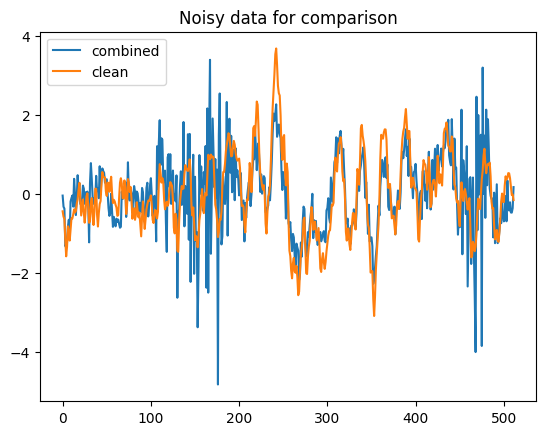

In [94]:
_, dl_test = create_dataloader(None, [NoiseTypeEnum.EMG])

combined, clean = next(iter(dl_test))
combined.shape
plt.plot(combined)
plt.plot(clean)
plt.legend(['combined', 'clean'])
plt.title("Noisy data for comparison")
plt.show()

# FCNN 01  

Final loss (train): 67.18
Final loss (test): 300.88


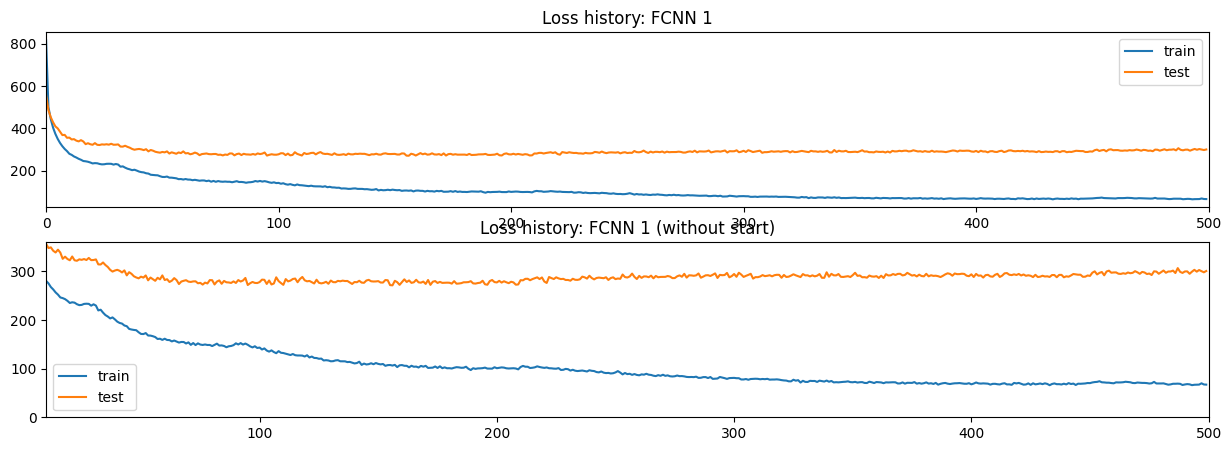

In [95]:
print_loss_history("FCNN 1", "results/FCNN_01_both/loss_history/loss_history_499.pickle")

In [96]:
model_fcnn_01 = ModelFactory.FCNN_01()
model_fcnn_01.load_state_dict( torch.load('results/FCNN_01_both/model/epoch_120.pth'))
calculate_stats_on_test_data(model_fcnn_01, NoiseTypeEnum.EOG)
calculate_stats_on_test_data(model_fcnn_01, NoiseTypeEnum.EMG)

Noise: EOG
R2: 0.44
MAE: 0.59
MSE: 0.56
RMSE: 0.74
Noise: EMG
R2: 0.39
MAE: 0.62
MSE: 0.61
RMSE: 0.78


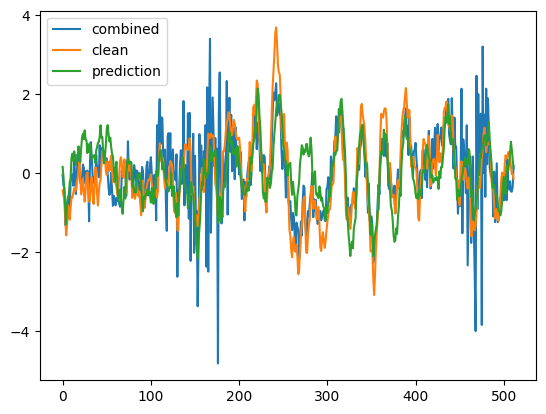

In [97]:
compare_prediction(model_fcnn_01, combined, clean)

# FCNN 02

Final loss (train): 225.44
Final loss (test): 318.64


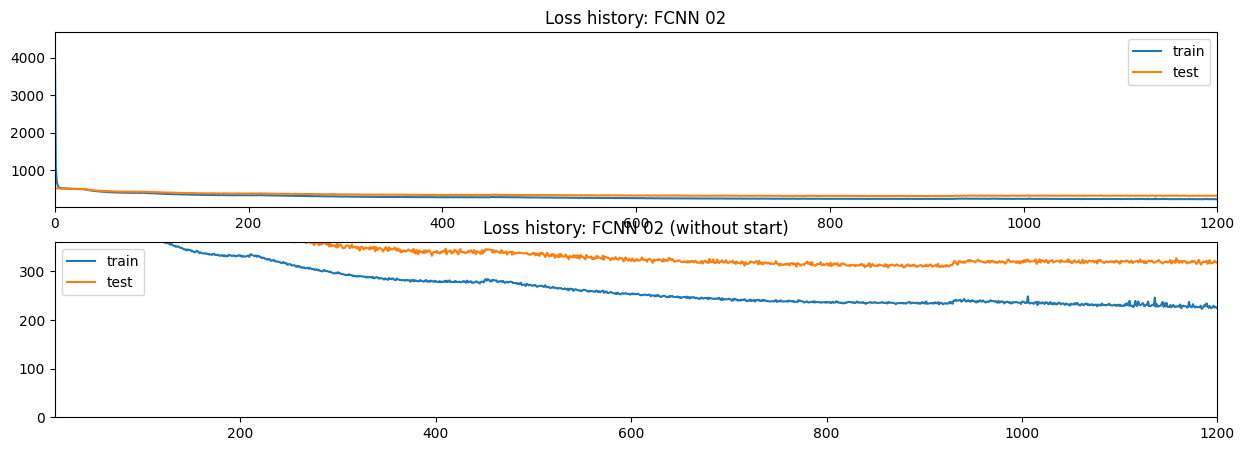

In [98]:
print_loss_history("FCNN 02", "results/FCNN_02_both/loss_history/loss_history_1199.pickle", skip = 50)

In [99]:
model_fcnn_02 = ModelFactory.FCNN_02()
model_fcnn_02.load_state_dict( torch.load('results/FCNN_02_both/model/epoch_900.pth'))
calculate_stats_on_test_data(model_fcnn_02, NoiseTypeEnum.EOG)
calculate_stats_on_test_data(model_fcnn_02, NoiseTypeEnum.EMG)

Noise: EOG
R2: 0.36
MAE: 0.63
MSE: 0.64
RMSE: 0.79
Noise: EMG
R2: 0.35
MAE: 0.63
MSE: 0.65
RMSE: 0.80


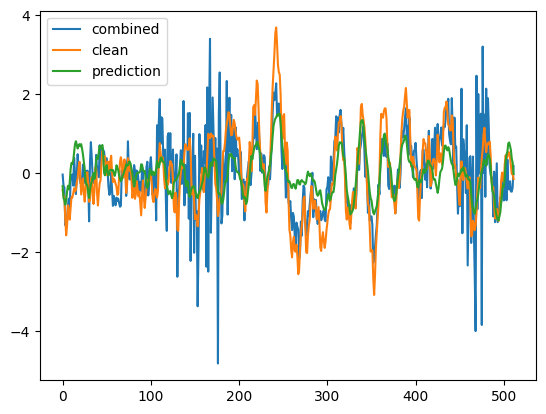

In [100]:
compare_prediction(model_fcnn_02, combined, clean)

# LSTM

Final loss (train): 98.29
Final loss (test): 292.94


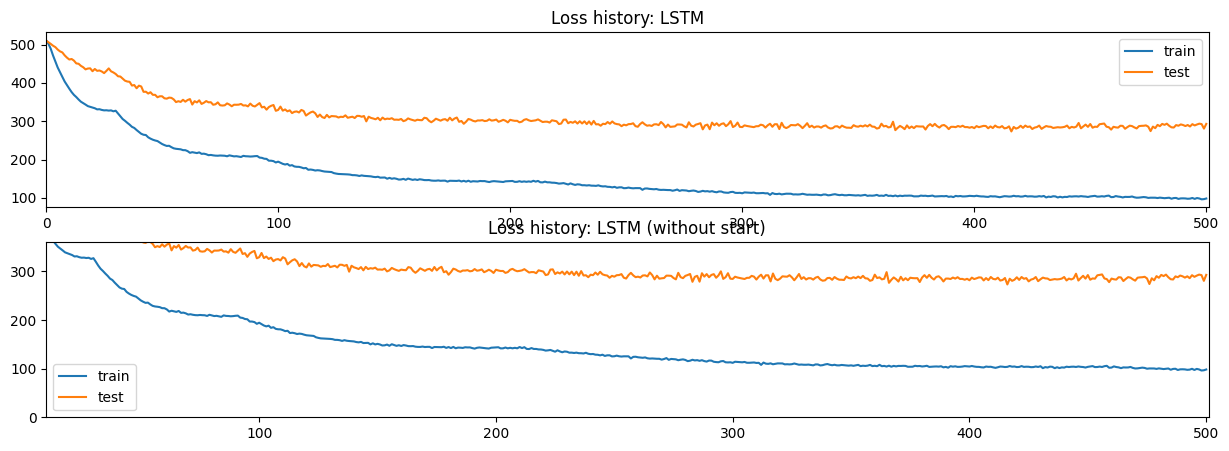

In [101]:
print_loss_history("LSTM", "results/LSTM_01/loss_history/loss_history_500.pickle", skip=10)

In [102]:
model_lstm = ModelFactory.LSTM_01()
model_lstm.load_state_dict(torch.load('results/LSTM_01/model/epoch_500.pth'))
calculate_stats_on_test_data(model_lstm, NoiseTypeEnum.EOG, cnn=True)
calculate_stats_on_test_data(model_lstm, NoiseTypeEnum.EMG, cnn=True)

Noise: EOG
R2: 0.46
MAE: 0.58
MSE: 0.54
RMSE: 0.73
Noise: EMG
R2: 0.45
MAE: 0.59
MSE: 0.55
RMSE: 0.74


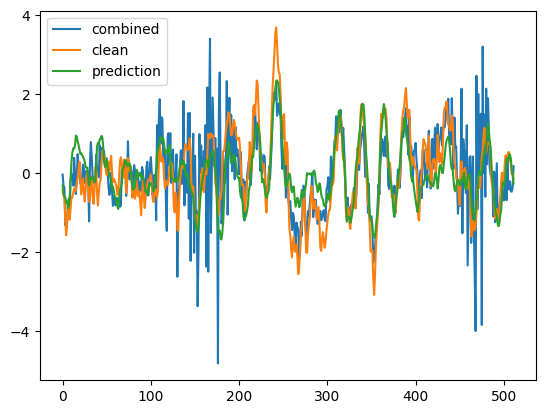

In [103]:
compare_prediction(model_lstm, combined, clean, cnn=True)

# CNN 01

Final loss (train): 164.96
Final loss (test): 176.77


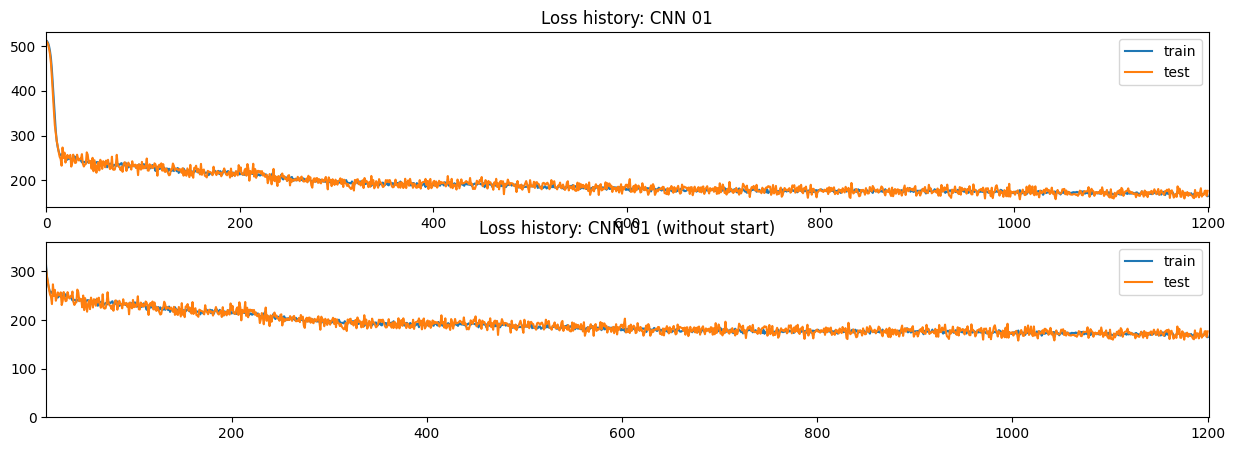

In [104]:
print_loss_history("CNN 01", "results/CNN_01_both/loss_history/loss_history_1200.pickle", skip=100)

In [105]:
model_cnn_01 = ModelFactory.CNN_01()
model_cnn_01.load_state_dict( torch.load('results/CNN_01_both/model/epoch_1200.pth'))
calculate_stats_on_test_data(model_cnn_01, NoiseTypeEnum.EOG, cnn=True)
calculate_stats_on_test_data(model_cnn_01, NoiseTypeEnum.EMG, cnn=True)
# combined.shape
# prediction = model(combined).detach().numpy()


Noise: EOG
R2: 0.53
MAE: 0.52
MSE: 0.47
RMSE: 0.68
Noise: EMG
R2: 0.56
MAE: 0.50
MSE: 0.44
RMSE: 0.63


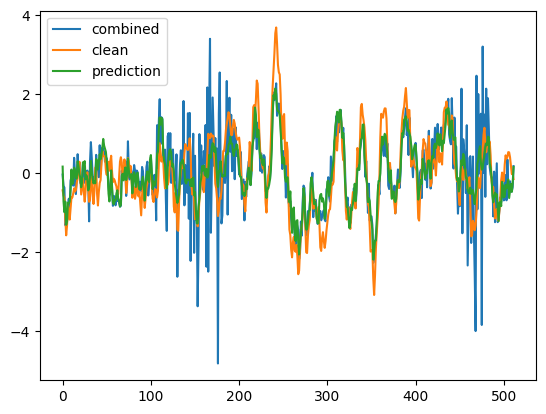

In [106]:
compare_prediction(model_cnn_01, combined, clean, cnn=True)

# CNN 02

Final loss (train): 241.36
Final loss (test): 173.51


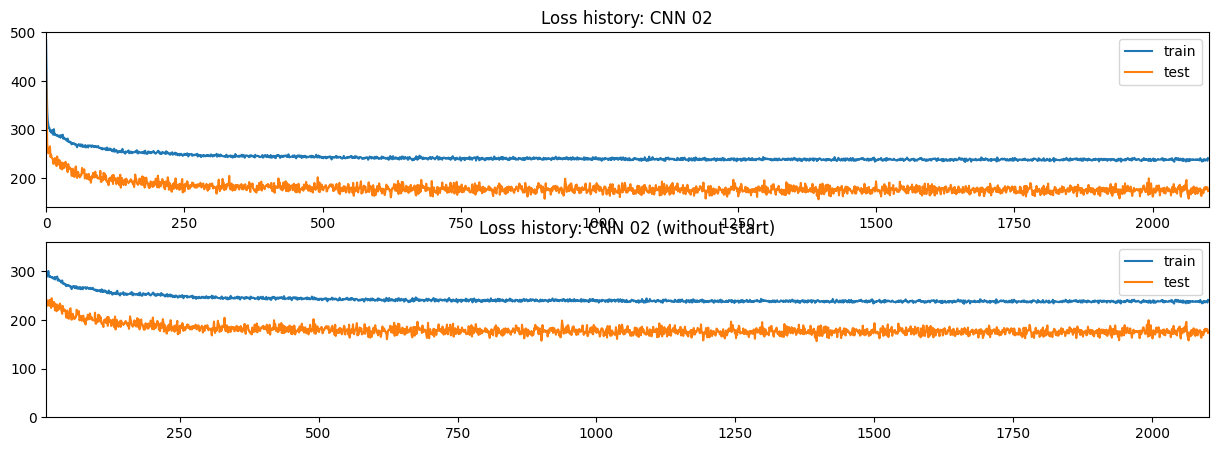

In [107]:
print_loss_history("CNN 02", "results/CNN_02/loss_history/loss_history_2100.pickle")

In [108]:
model_cnn_02 = ModelFactory.CNN_02()
model_cnn_02.load_state_dict( torch.load('results/CNN_02/model/epoch_2100.pth'))
calculate_stats_on_test_data(model_cnn_02, NoiseTypeEnum.EOG, cnn=True)
calculate_stats_on_test_data(model_cnn_02, NoiseTypeEnum.EMG, cnn=True)

Noise: EOG
R2: 0.54
MAE: 0.52
MSE: 0.46
RMSE: 0.67
Noise: EMG
R2: 0.54
MAE: 0.52
MSE: 0.46
RMSE: 0.66


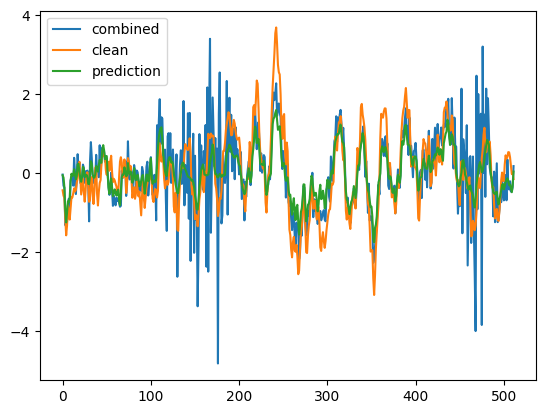

In [109]:
compare_prediction(model_cnn_02, combined, clean, cnn=True)

# CNN 03

Final loss (train): 108.17
Final loss (test): 174.95


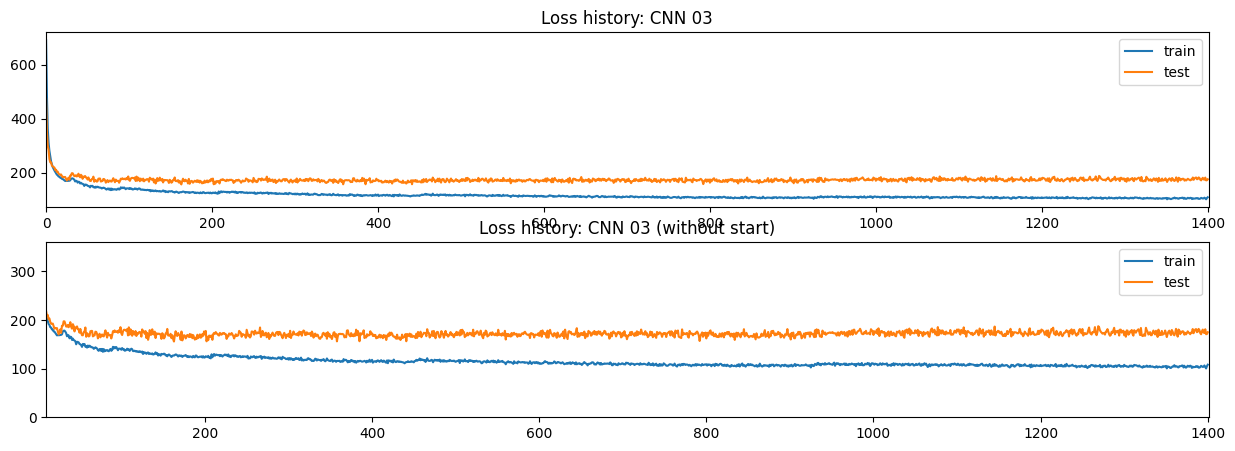

In [110]:
print_loss_history("CNN 03", "results/CNN_03/loss_history/loss_history_1400.pickle", skip=100)

In [111]:
model_cnn_03 = ModelFactory.CNN_03()
model_cnn_03.load_state_dict( torch.load('results/CNN_03/model/epoch_900.pth'))
calculate_stats_on_test_data(model_cnn_03, NoiseTypeEnum.EOG, cnn=True)
calculate_stats_on_test_data(model_cnn_03, NoiseTypeEnum.EMG, cnn=True)

Noise: EOG
R2: 0.61
MAE: 0.48
MSE: 0.39
RMSE: 0.62
Noise: EMG
R2: 0.57
MAE: 0.51
MSE: 0.43
RMSE: 0.64


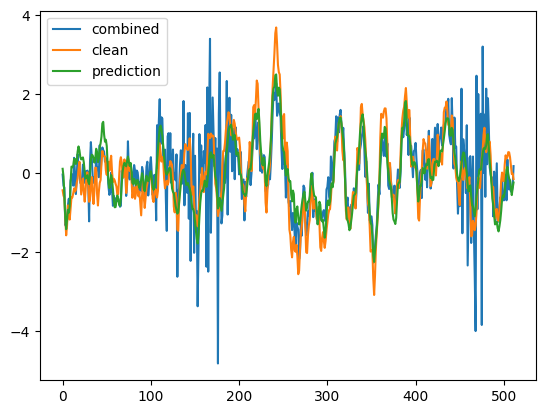

In [112]:
compare_prediction(model_cnn_03, combined, clean, cnn=True)

# CNN 03 EOG only

In [113]:
model_cnn_03_eog = ModelFactory.CNN_03()
model_cnn_03_eog.load_state_dict( torch.load('results/CNN_03_EOG/model/epoch_220.pth'))
calculate_stats_on_test_data(model_cnn_03_eog, NoiseTypeEnum.EOG, cnn=True)
calculate_stats_on_test_data(model_cnn_03_eog, NoiseTypeEnum.EMG, cnn=True)

Noise: EOG
R2: 0.62
MAE: 0.48
MSE: 0.38
RMSE: 0.61
Noise: EMG
R2: 0.44
MAE: 0.58
MSE: 0.56
RMSE: 0.74


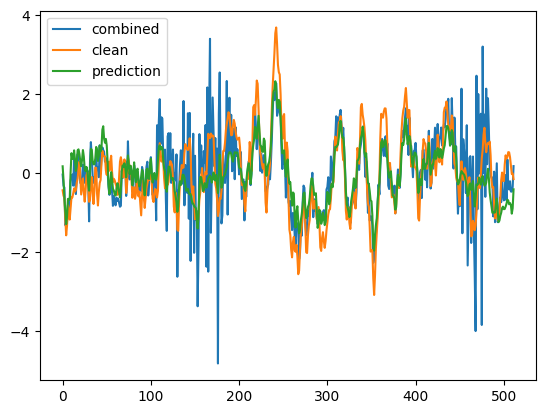

In [114]:
compare_prediction(model_cnn_03_eog, combined, clean, cnn=True)

# CNN 03 EMG only

In [115]:
model_cnn_03_emg = ModelFactory.CNN_03()
model_cnn_03_emg.load_state_dict( torch.load('results/CNN_03_EMG/model/epoch_250.pth'))
calculate_stats_on_test_data(model_cnn_03_emg, NoiseTypeEnum.EOG, cnn=True)
calculate_stats_on_test_data(model_cnn_03_emg, NoiseTypeEnum.EMG, cnn=True)

Noise: EOG
R2: 0.32
MAE: 0.61
MSE: 0.68
RMSE: 0.80
Noise: EMG
R2: 0.56
MAE: 0.51
MSE: 0.44
RMSE: 0.64


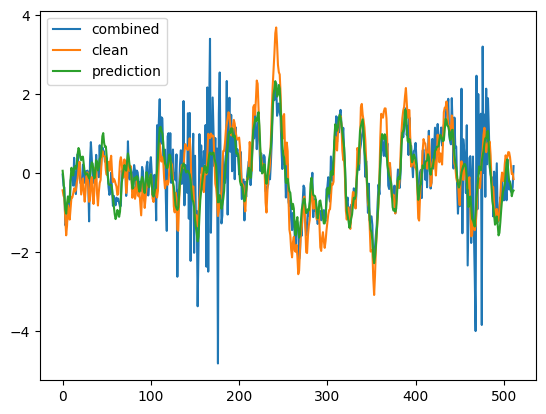

In [116]:
compare_prediction(model_cnn_03_emg, combined, clean, cnn=True)